In [7]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
import matplotlib.pyplot as plt
from shapely import wkt
from math import ceil
from shapely.geometry import box

In [66]:
raw_df[raw_df['recordedBy'] == 'heather340']

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,identifiedBy,dateIdentified,recordedBy


In [2]:
# Read OBIS occurence data into dataframe
raw_df = pd.read_csv('data\OBIS_anemone_occurrences_slim.tsv', sep='\t')
raw_df['geometry'] = raw_df['geometry'].apply(wkt.loads)
raw_gdf = gpd.GeoDataFrame(raw_df, geometry='geometry', crs=4326)

# Transform occurence data to Behrmann projection
behrmann_occurences_gdf = raw_gdf.to_crs("ESRI:54017")

In [67]:
# Read GBIF occurence data into dataframe
raw_df = pd.read_csv('data\GBIF_species_ID_complete.csv')

In [4]:
## DATA CLEANING & PREPROCESSING
# Remove null coordinates
raw_df = raw_df.dropna(subset=['decimalLongitude', 'decimalLatitude'])

# Remove points at origin (coordinate 0, 0)
raw_df = raw_df[(raw_df[['decimalLongitude','decimalLatitude']] != 0).all(axis=1)]

In [5]:
# Read into geodataframe
raw_gdf = gpd.GeoDataFrame(
    raw_df, 
    geometry=gpd.points_from_xy(raw_df['decimalLongitude'], raw_df['decimalLatitude']),
    crs='EPSG:4326'
)

# Transform to Behrmann projection
behrmann_raw_gdf = raw_gdf.to_crs('ESRI:54017')

In [6]:
# Read Natural Lands ocean map
ocean_gdf = gpd.read_file('data\\ne_10m_ocean.shp', crs='ESRI:4326')

# Transform to Behrmann projection
ocean_gdf = ocean_gdf.to_crs('ESRI:54017')

# Remove occurence points 10km or more inland
ocean_10km_buffer = ocean_gdf.buffer(10000)
occurences_gdf = behrmann_raw_gdf.clip(ocean_10km_buffer)


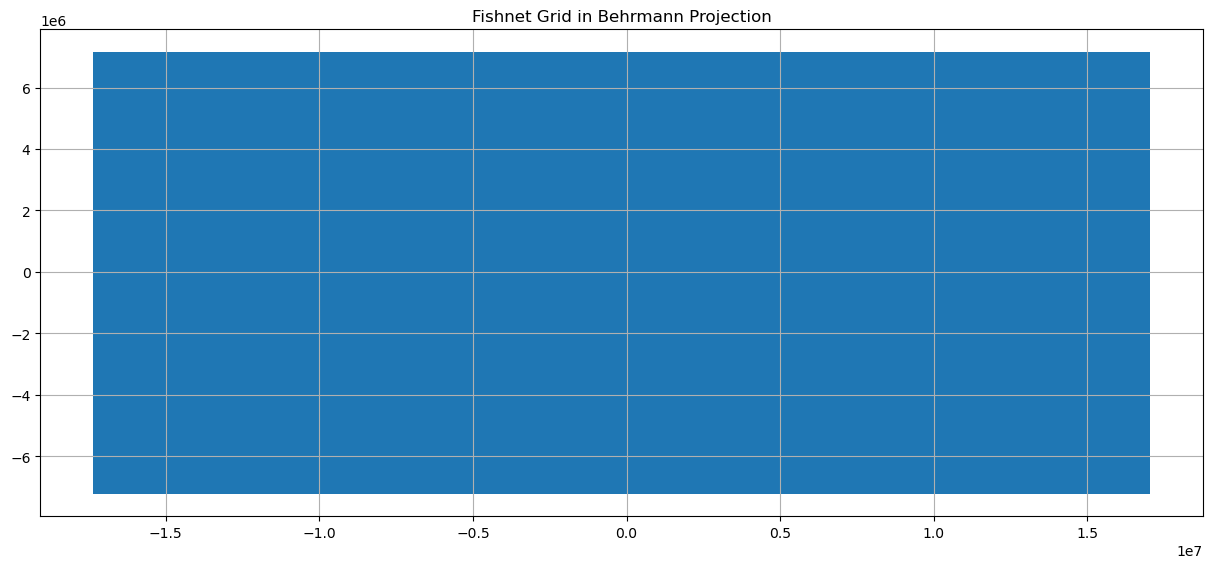

In [9]:
def create_fishnet(grid_size, bbox, projection):
    # Initialize the transformer to convert from geographic (longitude, latitude) to Behrmann projection
    transformer = Transformer.from_crs("EPSG:4326", projection, always_xy=True)
    
    # Transform the bounding box coordinates to the projection
    min_x, min_y = transformer.transform(bbox[0], bbox[1])
    max_x, max_y = transformer.transform(bbox[2], bbox[3])
    
    # Calculate number of cells needed in the x and y directions
    x_cells = ceil(int((max_x - min_x) / grid_size))
    y_cells = ceil(int((max_y - min_y) / grid_size))
    
    # Generate polygons for each cell in the grid
    polygons = []
    tile_ids = []
    for i in range(x_cells):
        for j in range(y_cells):
            # Coordinates of the lower left corner of the grid cell
            x1 = min_x + i * grid_size
            y1 = min_y + j * grid_size
            # Create a polygon for the grid cell
            poly = box(x1, y1, x1 + grid_size, y1 + grid_size)
            tile_id = f"{i}_{j}"
            polygons.append(poly)
            tile_ids.append(tile_id)
    
    # Create a GeoDataFrame from the polygons
    grid = gpd.GeoDataFrame({'tile_id': tile_ids, 'geometry': polygons}, crs=projection)
    return grid

# Define bounding box in geographic coordinates [min_lon, min_lat, max_lon, max_lat]
bbox = [-180, -80, 180, 80]  # Adjust latitude as per the usability in cylindrical projections

# Grid size in meters (e.g., 1000 km)
grid_size = 800000

# Create the fishnet grid
grid = create_fishnet(grid_size, bbox, "ESRI:54017")

# Plot the grid
fig, ax = plt.subplots(figsize=(15, 8))
grid.plot(ax=ax)
plt.title('Fishnet Grid in Behrmann Projection')
plt.grid(True)
plt.show()


In [10]:
# Join occurence data to grid
occurences_joined_gdf = occurences_gdf.sjoin(grid, how="inner", predicate="within")

In [11]:
occurences_joined_gdf['tile_id'].value_counts()

tile_id
21_16    89828
20_16    19848
6_15     16244
7_14     14386
6_14     14195
         ...  
0_13         1
11_7         1
31_9         1
16_15        1
14_14        1
Name: count, Length: 356, dtype: int64

### Aegean Anemone Analysis

In [54]:
cypriot_occurences = occurences_joined_gdf[occurences_joined_gdf['tile_id'] == '25_14'].drop('index_right', axis=1)
cypriot_geom = grid[grid['tile_id'] == '25_14']['geometry'].item()

aegean_occurences = occurences_joined_gdf[occurences_joined_gdf['tile_id'] == '24_14'].drop('index_right', axis=1)
aegean_geom = grid[grid['tile_id'] == '24_14']['geometry'].item()

sicilian_occurences = occurences_joined_gdf[occurences_joined_gdf['tile_id'] == '23_14'].drop('index_right', axis=1)
sicilian_geom = grid[grid['tile_id'] == '23_14']['geometry'].item()

In [55]:
def create_subgrid(geom):
    min_x, min_y, max_x, max_y = geom.bounds
    x_cells = int((max_x - min_x) / 2000)
    y_cells = int((max_y - min_y) / 2000)

    polygons = []
    tile_ids = []
    for i in range(x_cells):
        for j in range(y_cells):
            # Coordinates of the lower left corner of the grid cell
            x1 = min_x + i * 2000
            y1 = min_y + j * 2000
            # Create a polygon for the grid cell
            poly = box(x1, y1, x1 + 2000, y1 + 2000)
            tile_id = f"{i}_{j}"
            polygons.append(poly)
            tile_ids.append(tile_id)

    return gpd.GeoDataFrame({'subgrid_id': tile_ids, 'geometry': polygons}, crs='ESRI:54017')

In [56]:
cypriot_subgrid = create_subgrid(cypriot_geom)
cypriot_occurences_joined = cypriot_occurences.sjoin(cypriot_subgrid, how='inner', predicate='within').drop('index_right', axis=1)


aegean_subgrid = create_subgrid(aegean_geom)
aegean_occurences_joined = aegean_occurences.sjoin(aegean_subgrid, how='inner', predicate='within').drop('index_right', axis=1)

sicilian_subgrid = create_subgrid(sicilian_geom)
sicilian_occurences_joined = sicilian_occurences.sjoin(sicilian_subgrid, how='inner', predicate='within').drop('index_right', axis=1)

In [57]:
sicilian_occurences_joined

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,basisOfRecord,institutionCode,collectionCode,catalogNumber,identifiedBy,dateIdentified,recordedBy,geometry,tile_id,subgrid_id
76443,4116139357,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/16120...,Animalia,Cnidaria,Anthozoa,Actiniaria,Actiniidae,Actinia,Actinia cari,...,HUMAN_OBSERVATION,iNaturalist,Observations,161208834,michelina_m,2023-05-12T10:22:20,michelina_m,POINT (1781053.080 4730186.159),23_14,374_379
55332,3398895679,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/98882221,Animalia,Cnidaria,Anthozoa,Actiniaria,Actiniidae,Actinia,Actinia mediterranea,...,HUMAN_OBSERVATION,iNaturalist,Observations,98882221,Fran√ßois Roche,2021-10-21T17:29:12,Andrea Mosini,POINT (1454653.405 4370072.413),23_14,211_199
55509,3985895907,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/14275...,Animalia,Cnidaria,Anthozoa,Actiniaria,Actiniidae,Anemonia,Anemonia viridis,...,HUMAN_OBSERVATION,iNaturalist,Observations,142757433,Alessandro Mazzoleni,2022-11-24T17:02:58,Alessandro Mazzoleni,POINT (1458628.833 4379823.363),23_14,213_204
55648,4129987292,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/16521...,Animalia,Cnidaria,Anthozoa,Actiniaria,Actiniidae,Actinia,Actinia mediterranea,...,HUMAN_OBSERVATION,iNaturalist,Observations,165219651,Stefan Pav,2023-06-03T09:56:43,Juraj Ahel,POINT (1457706.231 4389687.944),23_14,212_209
55650,2013708727,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/21082215,Animalia,Cnidaria,Anthozoa,Actiniaria,Actiniidae,Actinia,Actinia mediterranea,...,HUMAN_OBSERVATION,iNaturalist,Observations,21082215,pierrenoel,2019-03-09T16:54:24,Steven Schulting,POINT (1457637.533 4389722.312),23_14,212_209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76640,1933570862,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/17928611,Animalia,Cnidaria,Anthozoa,Actiniaria,Actiniidae,Condylactis,Condylactis aurantiaca,...,HUMAN_OBSERVATION,iNaturalist,Observations,17928611,Gianfrs,2018-10-29T07:09:31,Gianfrs,POINT (1666938.177 4744004.322),23_14,317_386
76647,2028513367,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/21451945,Animalia,Cnidaria,Anthozoa,Actiniaria,Hormathiidae,Calliactis,Calliactis parasitica,...,HUMAN_OBSERVATION,iNaturalist,Observations,21451945,Gianfrs,2019-03-21T15:38:38,Gianfrs,POINT (1665046.950 4745025.759),23_14,316_387
76683,1946341536,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18652303,Animalia,Cnidaria,Anthozoa,Actiniaria,Sagartiidae,Cereus,Cereus pedunculatus,...,HUMAN_OBSERVATION,iNaturalist,Observations,18652303,Gianfrs,2018-11-26T16:11:07,Gianfrs,POINT (1659669.576 4748844.599),23_14,313_389
76721,1933546874,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/17709311,Animalia,Cnidaria,Anthozoa,Actiniaria,Actiniidae,Paranemonia,Paranemonia cinerea,...,HUMAN_OBSERVATION,iNaturalist,Observations,17709311,Gianfrs,2018-10-21T14:30:19,Gianfrs,POINT (1666798.755 4753344.275),23_14,317_391


In [60]:
def species_counts(df):
    return df['species'].value_counts().to_list()

aegean_assemblage = species_counts(aegean_occurences_joined)
print(aegean_assemblage)

cypriot_assemblage = species_counts(cypriot_occurences_joined)
difference = len(aegean_assemblage) - len(cypriot_assemblage)
cypriot_assemblage.extend([0] * difference)
print(cypriot_assemblage)

sicilian_assemblage = species_counts(sicilian_occurences_joined)
print(sicilian_assemblage)


[118, 104, 55, 40, 10, 7, 7, 6, 5, 4, 4, 2, 2, 2, 1, 1, 1, 1]
[39, 26, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[75, 61, 11, 11, 7, 7, 7, 4, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]


In [61]:
export_df = pd.DataFrame(aegean_assemblage, columns=['24_14'])
export_df['25_14'] = cypriot_assemblage
export_df['23_14'] = sicilian_assemblage


In [62]:
export_df

,24_14,25_14,23_14
0,118,39,75
1,104,26,61
2,55,2,11
3,40,1,11
4,10,1,7
5,7,1,7
6,7,1,7
7,6,1,4
8,5,1,3
9,4,1,2


In [63]:
# Export the DataFrame to a text file without the index
export_df.to_csv('output_test_w_sicilian.txt', sep=' ', index=False)